### (E) Logistic regression 

#### Instructions

Another strong baseline to evaluate is logistic regression

1. Evaluate a **logistic regression model** (without any hyperparameters tuning)
2. **Tune its regularization strength parameter with cross-validated grid-search** and compare the accuracy to the untuned one
3. Pick ten images and **compute the probability for each class** using the $predict_proba()$ function of your estimator. Plot the results for each image and comment your findings. For example, you can plot the ten images in subplots and collect the probabilities in a DataFrame *(see picture below!)*
4. Finally, **vary the regularization strength of your estimator**. What is the **effect on the probabilities?** Write your observations in a markdown cell.

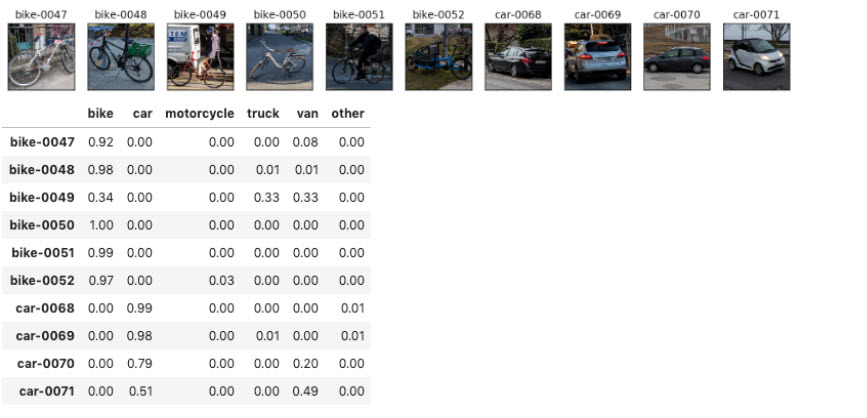

In [1]:
from IPython.display import Image
Image(filename="bike2.jpg")

**Note:** *Running a cross-validation on top of a grid search can computationally be very demanding. Under certain conditions, this might lead to a "never ending" model fit. We recommend that you use GridSearchCV together with verbose=1 to better understand how the computation is progressing. Also, if your computer provides parallel computation, you can use n_jobs=2 (or 4, 8 or -1) to specify how many parallel computation you want to allow.*

#### Load data

In [2]:
import numpy as np
import pandas as pd

In [3]:
with np.load('swissroads_highlevel_features.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    features_tr = npz_file['features_train']
    labels_tr = npz_file['labels_train']
    features_va = npz_file['features_valid']
    labels_va = npz_file['labels_valid']
    features_te = npz_file['features_test']
    labels_te = npz_file['labels_test']
    imgs_tr = npz_file['imgs_train']
    imgs_va = npz_file['imgs_valid']
    imgs_te = npz_file['imgs_test']

print('features_tr:', features_tr.shape)
print('labels_tr:', labels_tr.shape)
print('features_va:', features_va.shape)
print('labels_va:', labels_va.shape)
print('features_te:', features_te.shape)
print('labels_te:', labels_te.shape)
print('imgs_tr:', imgs_tr.shape)
print('imgs_va:', imgs_va.shape)
print('imgs_te:', imgs_te.shape)

features_tr: (280, 2048)
labels_tr: (280,)
features_va: (139, 2048)
labels_va: (139,)
features_te: (50, 2048)
labels_te: (50,)
imgs_tr: (280, 299, 299, 3)
imgs_va: (139, 299, 299, 3)
imgs_te: (50, 299, 299, 3)


In [4]:
X_tr = features_tr
X_va = features_va
X_te = features_te
y_tr = labels_tr
y_va = labels_va
y_te = labels_te
labels = ['bike','car','motorcycle','other','truck','van']

### Task E

#### i) Simple logistic regression with default parameters

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [6]:
# Create the estimator
logreg = Pipeline([
    ('scaler',StandardScaler()),
    ('logistic',LogisticRegression(multi_class='ovr',solver='liblinear')) # default
])

# Fit it to train set
logreg.fit(X_tr, y_tr)

# accuracy on validation set
print('Accuracy validation: {:.3f}'.format(logreg.score(X_va, y_va)))

Accuracy validation: 0.921


In [7]:
print('Predicted labels validation:',logreg.predict(X_va)[:5])
print('Actual labels validation:',y_va[:5])
print('Predicted probabilities validation:')
print(np.around(logreg.predict_proba(X_va)[:5],3))

Predicted labels validation: [3. 0. 0. 0. 0.]
Actual labels validation: [0. 0. 0. 0. 0.]
Predicted probabilities validation:
[[0.449 0.    0.    0.454 0.094 0.002]
 [0.723 0.001 0.    0.193 0.    0.083]
 [0.761 0.002 0.    0.234 0.    0.002]
 [0.97  0.001 0.    0.001 0.015 0.014]
 [0.665 0.    0.    0.001 0.001 0.334]]


#### ii) Tuning hyperparameters with GridSearchCV (grid search and cross validation)

**Merging train and validation sets for the use of cross-validation**

In [8]:
X_tr_va = np.concatenate((X_tr,X_va))
y_tr_va = np.concatenate((y_tr, y_va))

imgs_tr_va = np.concatenate((imgs_tr, imgs_va))
labels_tr_va = np.concatenate((labels_tr, labels_va))

In [9]:
print('Shape train/valid input:',X_tr_va.shape)
print('Shape train/valid output:',y_tr_va.shape)
print('Shape train/valid imgs:',imgs_tr_va.shape)
print('Shape train/valid labels:',labels_tr_va.shape)

Shape train/valid input: (419, 2048)
Shape train/valid output: (419,)
Shape train/valid imgs: (419, 299, 299, 3)
Shape train/valid labels: (419,)


In [10]:
# Create the estimator
logreg2 = Pipeline([
    ('scaler',StandardScaler()),
    ('logistic',LogisticRegression(multi_class='ovr',solver='liblinear'))
])

# Fit on the train/validation set
logreg2.fit(X_tr_va,y_tr_va)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
logreg2.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])>

In [13]:
# Create grid
grid = [{
    'logistic__C':np.logspace(-4,4,10),
    'logistic__multi_class':['ovr'],
    'logistic__solver':['liblinear']
},{
    'logistic__C':np.logspace(-4,4,10),
    'logistic__multi_class':['multinomial'],
    'logistic__solver':['saga']
}]

# Create cross validation object
grid_cv = GridSearchCV(estimator=logreg2, param_grid=grid, n_jobs=4, refit=True, cv=10, verbose=1, return_train_score=True)

In [14]:
grid_cv.fit(X_tr_va,y_tr_va)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.0min finished
C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'logistic__C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]), 'logistic__multi_class': ['ovr'], 'logistic__solver': ['liblinear']}, {'logistic__C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]), 'logistic__multi_class': ['multinomial'], 'logistic__solver': ['saga']}],
       p

In [15]:
# Get the results with "cv_results"
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_logistic__C', 'param_logistic__multi_class', 'param_logistic__solver', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [16]:
grid_cv.cv_results_['mean_test_score']

array([0.91408115, 0.93078759, 0.92601432, 0.92840095, 0.92362768,
       0.92124105, 0.92124105, 0.92601432, 0.93556086, 0.93794749,
       0.91408115, 0.92840095, 0.94033413, 0.94033413, 0.94033413,
       0.93556086, 0.94033413, 0.93794749, 0.93317422, 0.93794749])

In [17]:
cols = ['mean_test_score','mean_train_score','std_test_score','std_train_score','param_logistic__C','param_logistic__multi_class']
grid_cv_df = pd.DataFrame(grid_cv.cv_results_)[cols].sort_values(by='mean_test_score', ascending=False)
grid_cv_df

,mean_test_score,mean_train_score,std_test_score,std_train_score,param_logistic__C,param_logistic__multi_class
12,0.940334,1.000000,0.035291,0.000000,0.00599484,multinomial
16,0.940334,1.000000,0.038390,0.000000,21.5443,multinomial
14,0.940334,1.000000,0.038390,0.000000,0.359381,multinomial
13,0.940334,1.000000,0.035291,0.000000,0.0464159,multinomial
19,0.937947,1.000000,0.038138,0.000000,10000,multinomial
9,0.937947,1.000000,0.033066,0.000000,10000,ovr
17,0.937947,1.000000,0.042353,0.000000,166.81,multinomial
8,0.935561,1.000000,0.041197,0.000000,1291.55,ovr
15,0.935561,1.000000,0.039144,0.000000,2.78256,multinomial
18,0.933174,1.000000,0.042773,0.000000,1291.55,multinomial


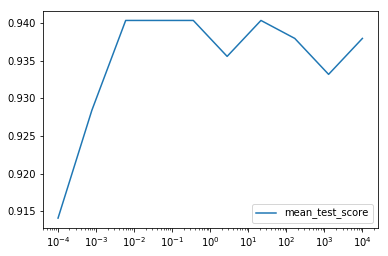

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

grid_cv_df_softmax = grid_cv_df[grid_cv_df['param_logistic__multi_class'] == 'multinomial'].sort_values(by='param_logistic__C')

# Plot test curve
plt.semilogx(grid_cv_df_softmax['param_logistic__C'], grid_cv_df_softmax['mean_test_score'])
plt.legend()
plt.show()
# Note the log scale on the x_axis

In [19]:
grid_cv.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=0.005994842503189409, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=False))])

#### iii) Pick then images and compte the probability for each class

**Picked images in train/validation set**
* Predictor is very accuracyfor all images. Seems to be slightly more difficult to predict when picture is taken from front or side without more angles

In [20]:
pick_10 = [0,14,45,76,78,99,111,132,233,300]
pick_10_test = [0,3,5,8,12,13,14,20,23,25]

In [21]:
grid_cv.predict(X_tr_va)[pick_10]

array([2., 5., 1., 1., 0., 2., 1., 5., 5., 0.], dtype=float32)

In [22]:
y_tr_va[pick_10]

array([2., 5., 1., 1., 0., 2., 1., 5., 5., 0.], dtype=float32)

In [23]:
pd.DataFrame(np.around(grid_cv.predict_proba(X_tr_va)[pick_10],3)).rename({0:labels[0],1:labels[1],2:labels[2],3:labels[3],4:labels[4],5:labels[5]}, axis=1)

,bike,car,motorcycle,other,truck,van
0,0.001,0.006,0.978,0.004,0.007,0.003
1,0.003,0.051,0.002,0.014,0.018,0.913
2,0.001,0.962,0.001,0.002,0.003,0.031
3,0.000,0.997,0.000,0.000,0.000,0.002
4,0.989,0.001,0.003,0.005,0.002,0.001
5,0.001,0.001,0.993,0.002,0.002,0.001
6,0.001,0.977,0.007,0.007,0.001,0.007
7,0.005,0.007,0.006,0.007,0.039,0.936
8,0.004,0.006,0.004,0.154,0.154,0.679
9,0.996,0.000,0.001,0.001,0.001,0.001


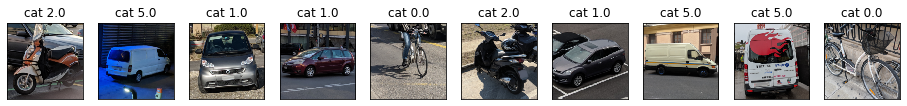

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(16, 16))

x = 0
for i in pick_10:
    #n = pd.DataFrame(labels_tr)[pd.DataFrame(labels_tr)[0] == category].index[0]

    axes[x].set_title('cat {}'.format(y_tr_va[i]))
    axes[x].imshow(imgs_tr_va[i])
    axes[x].get_xaxis().set_visible(False) # Disable x-axis
    axes[x].get_yaxis().set_visible(False) # Disable y-axis
    x = x + 1
plt.show()
# how to replace one-hot encoded by true names?

In [25]:
logistic_train_score = grid_cv.score(X_tr_va, y_tr_va)
logistic_test_score = grid_cv.score(X_te, y_te)

print('Accuracy Logistic Regression train set:',logistic_train_score)
print('Accuracy Logistic Regression test set:',logistic_test_score)

Accuracy Logistic Regression train set: 1.0
Accuracy Logistic Regression test set: 0.94


In [26]:
%store logistic_test_score

Stored 'logistic_test_score' (float64)


#### iv) Vary the regularization srength and check effect on probabilities

* with high regularization (lower C values) the probabilities are less extreme and get closer to wrongly predicting classes

In [27]:
logreg3 = Pipeline([
    ('scaler',StandardScaler()),
    ('logistic',LogisticRegression(C=200, multi_class='multinomial',solver='saga'))
])

logreg3.fit(X_tr_va, y_tr_va)

pd.DataFrame(np.around(logreg3.predict_proba(X_tr_va)[pick_10],3)).rename({0:labels[0],1:labels[1],2:labels[2],3:labels[3],4:labels[4],5:labels[5]}, axis=1)

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,bike,car,motorcycle,other,truck,van
0,0.0,0.000,1.0,0.000,0.000,0.000
1,0.0,0.004,0.0,0.001,0.001,0.994
2,0.0,0.998,0.0,0.000,0.000,0.002
3,0.0,1.000,0.0,0.000,0.000,0.000
4,1.0,0.000,0.0,0.000,0.000,0.000
5,0.0,0.000,1.0,0.000,0.000,0.000
6,0.0,1.000,0.0,0.000,0.000,0.000
7,0.0,0.000,0.0,0.000,0.002,0.998
8,0.0,0.000,0.0,0.024,0.015,0.961
9,1.0,0.000,0.0,0.000,0.000,0.000


In [28]:
logreg4 = Pipeline([
    ('scaler',StandardScaler()),
    ('logistic',LogisticRegression(C=0.01, multi_class='multinomial',solver='saga'))
])

logreg4.fit(X_tr_va, y_tr_va)

pd.DataFrame(np.around(logreg4.predict_proba(X_tr_va)[pick_10],3)).rename({0:labels[0],1:labels[1],2:labels[2],3:labels[3],4:labels[4],5:labels[5]}, axis=1)

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,bike,car,motorcycle,other,truck,van
0,0.001,0.004,0.985,0.003,0.005,0.002
1,0.002,0.036,0.001,0.009,0.012,0.940
2,0.000,0.975,0.001,0.001,0.001,0.022
3,0.000,0.998,0.000,0.000,0.000,0.001
4,0.993,0.000,0.001,0.003,0.001,0.001
5,0.000,0.000,0.996,0.001,0.001,0.001
6,0.001,0.985,0.005,0.005,0.001,0.004
7,0.003,0.004,0.004,0.005,0.027,0.957
8,0.002,0.004,0.003,0.120,0.112,0.759
9,0.998,0.000,0.000,0.001,0.001,0.000


#### Notes/Questions Task E (Greg)
* When using grid search shall I have also tuned other hyperparameters like 'softmax',differents folds, etc...or just for C in this case? *(cell 13)*
* Can I tune C after GridSearchCV directly or need to re-run all as I did ('with set_params'?)? *(cell 27)*